Import Libraries and Data

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras

dataset_name = 'tf_flowers'

making train and validation set

In [5]:
(dataset_train, dataset_val), dataset_info = tfds.load(
    dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)


# Get the class names from the dataset info
class_names = dataset_info.features['label'].names

# Initialize a dictionary to store class counts
class_counts = {name: 0 for name in class_names}

# Iterate through the dataset and count the images per class
for image, label in tfds.as_numpy(dataset_train):
    class_name = class_names[label]
    class_counts[class_name] += 1

for image, label in tfds.as_numpy(dataset_val):  # Iterate through the val dataset
    class_name = class_names[label]
    class_counts[class_name] += 1

# Print the class counts
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

counts_list = list(class_counts.values())
print(f"Counts per class: {counts_list}")

Class: dandelion, Count: 898
Class: daisy, Count: 633
Class: tulips, Count: 799
Class: sunflowers, Count: 699
Class: roses, Count: 641
Counts per class: [898, 633, 799, 699, 641]


In [6]:
for image, label in dataset_train.take(1):  # Take one example
    print("Label:", label.numpy())  # Print the label
# output is integer , so labels are integer and not one-hot encoded so we can use sparse_categorical_crossentropy as our loss function.



Label: 2


making test set

In [7]:
#(train_data, test_data), dataset_info = tfds.load(
  #  dataset_name, split=['train[:70%]', 'train[70%:]'], as_supervised=True, with_info=True)

data processing function - so that the nn can perform better when the images have the same size. normalization helps training by keeping pixel values in a same range.

.map(preprocess) applies preprocess() to every image and label in the dataset.

 .batch(batch_size) groups images into batches of 3 - cus it speeds up training , learns 32 images instead of one image at once. stabalizes learning as it is more effcient.

.prefetch(tf.data.AUTOTUNE) makes data loading faster by preloading the next batch while the model is training on the current batch. - reduces training time, utilizes cpu and gpu efficiently to avoid delays in fetching data.

the preprocess data is stored into the respective generator

In [8]:
batch_size = 32 # 32 images at a time
img_height = 180
img_width = 180

def preprocess(image, label):
  image = tf.image.resize(image, (img_height, img_width)) # resize image to (180,180)
  image = image / 255.0 # to make the pixel between 0 and 1 i.e normalize image to range [0,1]

  return image, label

train_data = dataset_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = dataset_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
#test_data = test_data.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_generator = train_data
val_generator = val_data
#test_generator = test_data

Defining the CNN Model

sequential() : to ensure that one layer after the other is implemented

kernel_regularizer=l2(0.01) :  L2 regularization to discourage very large weight values-> makes the model generalize better

In [9]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Import necessary layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
# new conv layer
#The CNN model
model = Sequential([
                    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=(180,180,3)),#layer 1
                    MaxPooling2D(2,2),
                    Conv2D(64, (3,3), activation='relu',kernel_regularizer=l2(0.0001)), #layer 2
                    MaxPooling2D(2,2),
                    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.0001)), #layer 3
                    MaxPooling2D(2,2),
                    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.0001)), #layer 4
                    MaxPooling2D(2,2),
                    #feature extraction completed.
                    Flatten(), # converts 2D feature map into 1D vector so it can be fed into the NN
                    Dense(256, activation='relu'), # hidden layer, fully connected layer with 128 neurons, learns the features.
                    Dropout(0.5), # to prevent overfitting : randomly turns off 50% of the neurons while training
                    Dense(5, activation='softmax') # output layer that classifies 5 classes
                  ])
#Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Training

history is a variable that stores the training results, which we can use later to visualize our training using matplotlib

model.fit() trains the model, it runs for multiple epochs (here 10)

the model takes batches of images + label from train_generator(pre-process train data).

it makes predictions and compares it to the true labels. It calculates the loss(how wrong the predictions are)

it adjusts the weights to imporove the model.

it repeats this for 10 epochs.

after each epoch, model makes predictions on the preprocessed validation set (val_generator), and calculates validation loss and validation accuracy.

validation_data is the parameter od model.fit() , is i have to write it as 'validation_data=val_generator'

Verbose = 1 , shows the progress bar


conv2d layer 3 as 128, dense as 128 didnt work

In [10]:
history = model.fit(train_generator, epochs=10, validation_data = val_generator,verbose = 1)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.3008 - loss: 1.5237 - val_accuracy: 0.5000 - val_loss: 1.1746
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5058 - loss: 1.1701 - val_accuracy: 0.5940 - val_loss: 1.0381
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5888 - loss: 1.0457 - val_accuracy: 0.6621 - val_loss: 0.9263
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6489 - loss: 0.9271 - val_accuracy: 0.6717 - val_loss: 0.8618
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6809 - loss: 0.8497 - val_accuracy: 0.6839 - val_loss: 0.8121
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7241 - loss: 0.7407 - val_accuracy: 0.7016 - val_loss: 0.8167
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7562 - loss: 0.6781 - val_accuracy: 0.7044 - val_loss: 0.8257
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7665 - loss: 0.6416 - val_accuracy: 0.7057 -

Model Evaluation

Plots

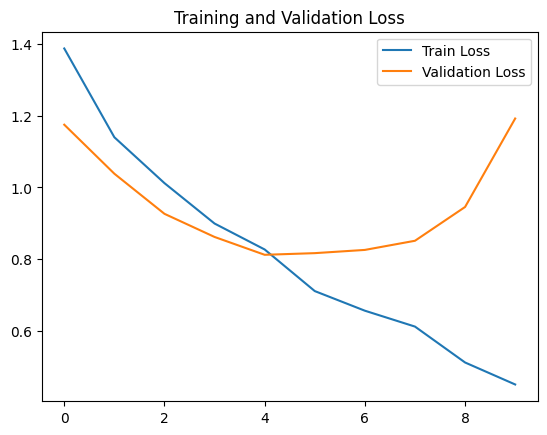

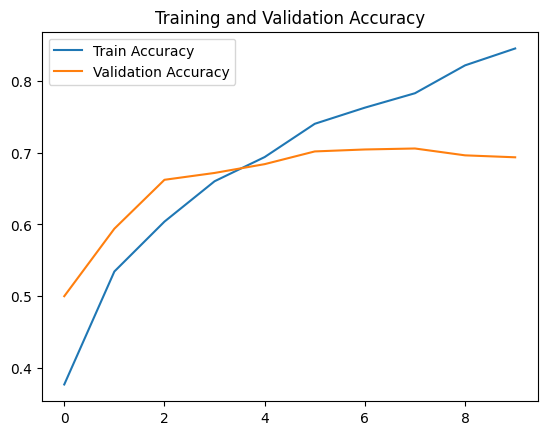

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8450 - loss: 0.4744
Test Accuracy: 86.72%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6882 - loss: 1.2549
Validation Accuracy: 69.35%


In [11]:
import matplotlib.pyplot as plt

# Training loss vs Validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Training Accuracy vs Validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate model
loss, accuracy = model.evaluate(train_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

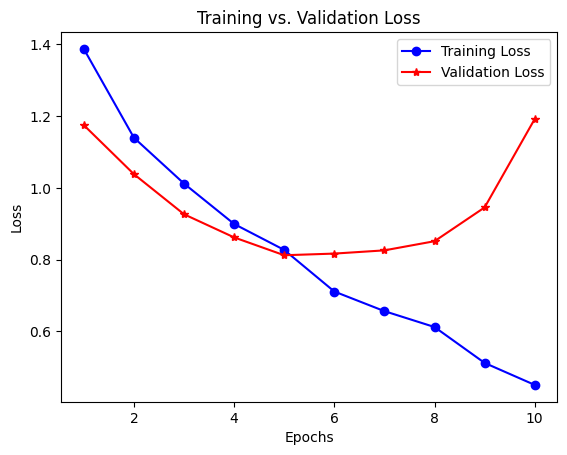

In [12]:
import matplotlib.pyplot as plt

# Get loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


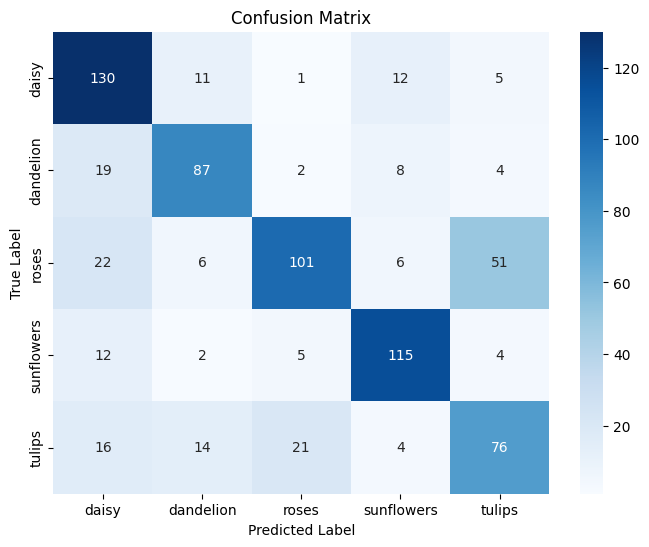

Classification Report:
               precision    recall  f1-score   support

       daisy       0.65      0.82      0.73       159
   dandelion       0.72      0.72      0.72       120
       roses       0.78      0.54      0.64       186
  sunflowers       0.79      0.83      0.81       138
      tulips       0.54      0.58      0.56       131

    accuracy                           0.69       734
   macro avg       0.70      0.70      0.69       734
weighted avg       0.70      0.69      0.69       734



In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# class in tf_flowers
class_names = ['daisy', 'dandelion','roses','sunflowers','tulips']

# Get true labels and predictions
y_true = []
y_pred = []


for images, labels in val_generator:
    predictions = model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())  # Store true labels
    y_pred.extend(np.argmax(predictions,axis=1))  # Convert probs to class labels using argmax
# grabs the index of the class with highest probability, for each image.

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred) #compares predictions vs. true labels.

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names = class_names))
#classification_report() — gives precision, recall, and F1-score per class


creating an image batch and making predictions

In [15]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_generator))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
['roses' 'sunflowers' 'sunflowers' 'roses' 'sunflowers' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'sunflowers' 'sunflowers'
 'roses' 'daisy' 'tulips' 'dandelion' 'daisy' 'roses' 'dandelion'
 'sunflowers' 'sunflowers' 'dandelion' 'sunflowers' 'tulips' 'daisy'
 'daisy' 'dandelion' 'sunflowers' 'roses' 'dandelion' 'tulips'
 'sunflowers']


plot model predictions

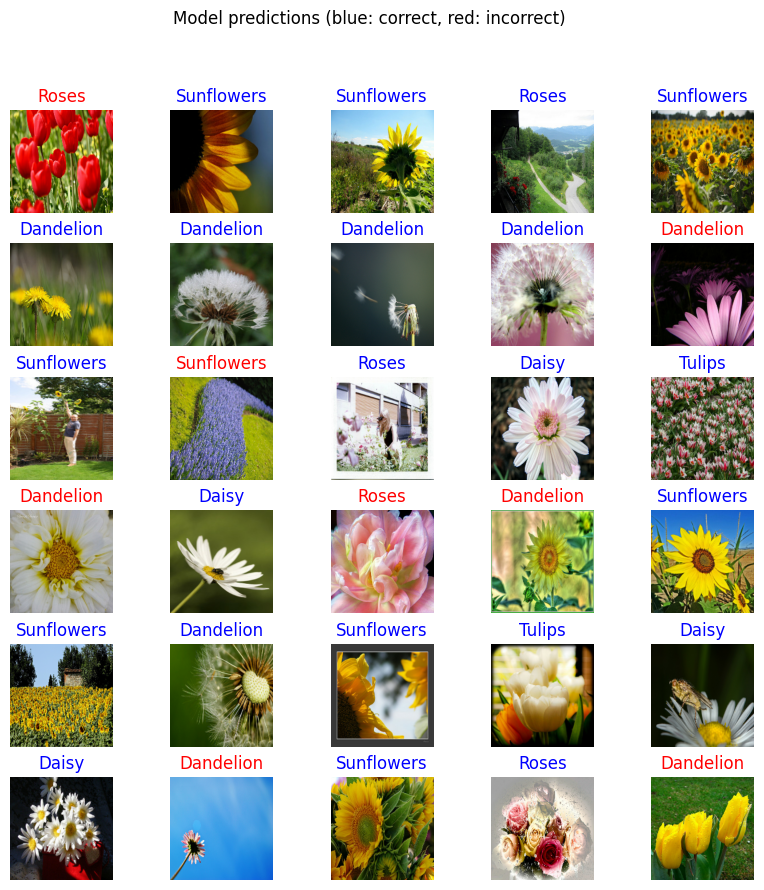

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
    plt.suptitle("Model predictions (blue: correct, red: incorrect)")